# relatorio_quick

Esse notebook pega frações de nuvens já processadas e faz sampling delas em períodos determinados (como por exemplo diáro ou semanal) para então plotar-las no tempo

In [200]:
import initialize
import common
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pylab
import scipy.stats as st
import scipy as sp
pylab.rcParams['figure.figsize'] = (15, 9)

In [201]:
## Arquivos com os dados de CF

proc_path = os.path.expanduser("~/dados-ic/processed/")
rad_path = os.path.join(proc_path, "rad.csv")
tsi_path = os.path.join(proc_path, "tsi.csv")
mod_path = os.path.join(proc_path, "modis-terra.csv")
myd_path = os.path.join(proc_path, "modis-aqua.csv")
goes_path = os.path.join(proc_path, "goes_acorreia.csv")

## Parte 1 - gerar gráfico temporal

In [202]:
## Criar uma dict com o nome e váriaveis de interessante para plot

d_list = {}

dat = pd.read_csv(tsi_path, na_values=["--"])
dat = common.convert_time(dat)
d = {"name": "TSI", "x": dat.Time, "y": dat.TSI_CloudFraction}
d_list["tsi"] = d

dat = pd.read_csv(rad_path, na_values=["--"])
dat = common.convert_time(dat)

## radflux

### Xie & Liu

d = {"name": "Xie & Liu", "x": dat.Time, "y": dat.XL_CloudFraction}
d_list["xl"] = d
d = {"name": "Xie & Liu corrected", "x": dat.Time, "y": dat.XL_CloudFractionCorrected}
d_list["xl_corr"] = d

### Long

inds = np.isfinite(dat.Long_SW_CloudFraction)
dat = dat[inds]
d = {"name": "Long (SW)", "x": dat.Time, "y": dat.Long_SW_CloudFraction}
d_list["long_sw"] = d
d = {"name": "Long (LW)", "x": dat.Time, "y": dat.Long_LW_CloudFraction}
d_list["long_lw"] = d

## modis

dat = pd.read_csv(mod_path, na_values=["--"])
dat = common.convert_time(dat)
inds = dat.Time.dt.hour > 10
inds &= dat.Time.dt.hour < 22
dat = dat[inds]
d = {"name": "MODIS Terra", "x": dat.Time, "y": dat.CloudFraction}
d_list["modterra"] = d

dat = pd.read_csv(myd_path, na_values=["--"])
dat = common.convert_time(dat)
inds = dat.Time.dt.hour > 10
inds &= dat.Time.dt.hour < 22
dat = dat[inds]
d = {"name": "MODIS Aqua", "x": dat.Time, "y": dat.CloudFraction}
d_list["modaqua"] = d

## goes

dat = pd.read_csv(goes_path, na_values=["--"])
dat.datetime = pd.to_datetime(dat.datetime)
d = {"name": "GOES-13", "x": dat.datetime, "y": dat.CF}
d_list["goes"] = d

In [203]:
## Fazer média de 7 dias

days = pd.date_range("2014-01-01", "2016-01-01", freq="7D")

nd_list = {}

for k in d_list.keys():
    x = d_list[k]["x"]
    y = d_list[k]["y"]
    nx = []
    ny = []
    for i in range(len(days) - 1):
        day0 = days[i]
        day1 = days[i + 1]
        inds = x > day0
        inds &= x < day1
        mean_ny = np.mean(y[inds])
        ny.append(mean_ny)
        nx.append(day0)
        print("\r%s - %s" % (k, len(days) - i), end="")
    print("")
    
    nd_list[k] = {"name": d_list[k]["name"],
                  "x": nx,
                  "y": ny}

long_lw - 200
modaqua - 200
xl_corr - 200
long_sw - 200
xl - 200
tsi - 200
modterra - 200
goes - 200


In [204]:
## 

def plot_aux(name, fig):
    d = nd_list[name]
    x = d["x"]
    y = d["y"]
    lab = d["name"]
    fig.plot(x, y, label=lab)
    fig.legend()
    fig.set_ylim((0, 1))
    fig.grid(color="k", linewidth=0.1)

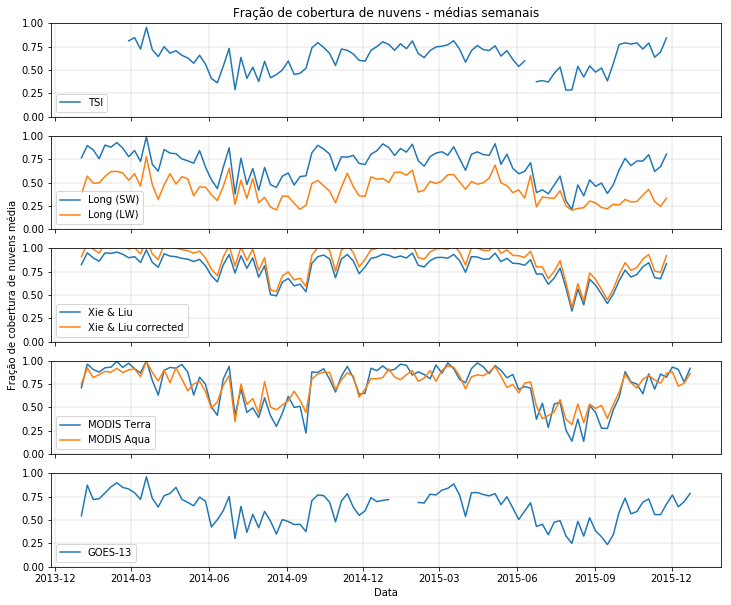

In [208]:
pylab.rcParams['figure.figsize'] = (12, 10)

f, axarr = plt.subplots(5, sharex=True)

plot_aux("tsi", axarr[0])

plot_aux("long_sw", axarr[1])
plot_aux("long_lw", axarr[1])

plot_aux("xl", axarr[2])
plot_aux("xl_corr", axarr[2])

plot_aux("modterra", axarr[3])
plot_aux("modaqua", axarr[3])

plot_aux("goes", axarr[4])

plt.xlabel("Data")

axarr[0].set_title("Fração de cobertura de nuvens - médias semanais")
axarr[2].set_ylabel("Fração de cobertura de nuvens média")

plt.show()

## Parte 2 - gerar histogramas do XL

In [209]:
raw = pd.read_csv(rad_path)

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


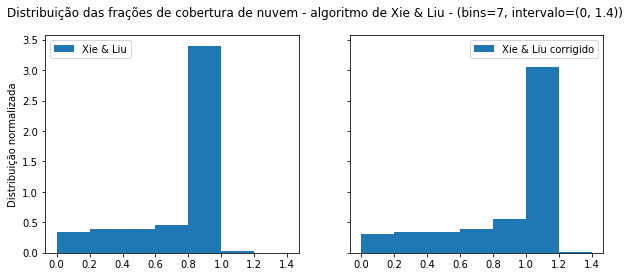

In [210]:
pylab.rcParams['figure.figsize'] = (10, 4)

f, axarr = plt.subplots(1, 2, sharey=True)
bins = 7
rang = (0, 1.4)
axarr[0].hist(raw.XL_CloudFraction - 1e-5, range=rang, normed=True, bins=bins, label="Xie & Liu")
axarr[0].set_ylabel("Distribuição normalizada")
axarr[0].legend()
axarr[1].hist(raw.XL_CloudFractionCorrected - 1e-5, range=rang, normed=True, bins=bins, label="Xie & Liu corrigido")
axarr[1].legend()
plt.suptitle("Distribuição das frações de cobertura de nuvem - algoritmo de Xie & Liu - (bins=%s, intervalo=%s)"  % (bins, rang))
plt.show()

In [211]:
N = len(raw.XL_CloudFraction)
XLp = np.sum(raw.XL_CloudFraction > 1) / N
XLcp = np.sum(raw.XL_CloudFractionCorrected > 1) / N
print("Quantidade de CF obtidas por Xie & Liu: %s" % N)
print("Proporção de CF de Xie & Liu acima de 1.0: %.3f", XLp)
print("Proporção de CF de Xie & Liu com correção acima de 1.0: % .3f", XLcp)


Quantidade de CF obtidas por Xie & Liu: 1018080
Proporção de CF de Xie & Liu acima de 1.0: %.3f 0.00920359893132
Proporção de CF de Xie & Liu com correção acima de 1.0: % .3f 0.211947980512


## Parte 3 - correlações

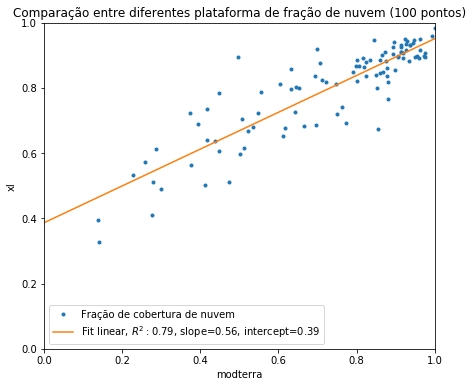

In [214]:
pylab.rcParams['figure.figsize'] = (7, 6)

name1 = "modterra"
name2 = "xl"

x = np.array(nd_list[name1]["y"])
y = np.array(nd_list[name2]["y"])

inds = np.isfinite(x)
inds &= np.isfinite(y)

x = x[inds]
y = y[inds]

(r, p) = st.pearsonr(x, y)

def f(x, slope, intercept):
    return intercept + x * slope

fit_output = sp.optimize.curve_fit(f, x, y)

slope = fit_output[0][0]
intercept = fit_output[0][1]

x_corr = np.linspace(0, 1, 100)
y_corr = slope * x_corr + intercept

plt.plot(x, y, '.', label="Fração de cobertura de nuvem")
plt.plot(x_corr, y_corr, label="Fit linear, $R^2: %.2f$, slope=$%.2f$, intercept=$%.2f$"
         % (r ** 2, slope, intercept))

plt.title("Comparação entre diferentes plataforma de fração de nuvem (%s pontos)" % len(x))
plt.legend()
plt.xlabel(name1)
plt.ylabel(name2)
plt.xlim((0, 1))
plt.ylim((0, 1))

plt.show()

In [193]:
slope

0.63836745048006216

In [72]:
np.sqrt(slope)

0.94409907836968787

In [198]:
raw = pd.read_csv(mod_path, na_values=("--"))
raw.Time = pd.to_datetime(raw.Time)
inds = np.isfinite(raw.CloudFraction)
#inds &= raw.Time.dt.hour < 10
#inds &= raw.Time.dt.hour > 22

dat = raw[inds]
len(dat)

1506

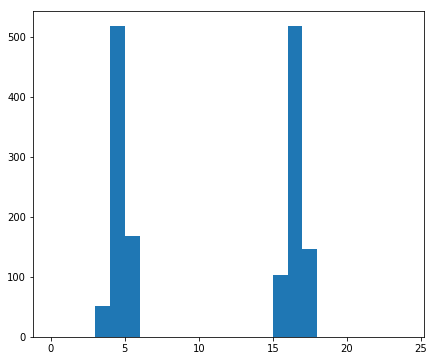

In [199]:
plt.hist(dat.Time.dt.hour, bins=24, range=(0, 24))
plt.show()